# Sentiment140
http://help.sentiment140.com/for-students/

Анализ эмоциональной окраски на основе корпуса твиттов Sentiment140. Корпус содержит 1 600 000 размеченых твиттов.

**Формат **

- 0 = negative 
- 4 = positive

Разметка твиттов была не ручная, а автоматическая на основе смайлов.

В начале проведем анализ исходного корпуса, без предварительной "очистки" твиттов.

Загружаем необходимые библиотеки:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import re
import pandas as pd

from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import roc_curve, auc

Считываем из корпуса только сами твитты и их эмоциональную окраску (колонки 'sentiment', 'tweet'): 0 = negative 4 = positive

In [2]:
df = pd.read_csv('Data/training.1600000.processed.noemoticon.csv', header=None, usecols=[0,5], names=['sentiment', 'tweet'])
df.head(3)

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...


Смотрим сколько считали из файла твиттов. Должно быть 1 600 000. Если это не так, значит ошибка

In [3]:
df.shape

(1600000, 2)

Преобразуем твитты в отдельные списки для удобства дальнейшего анализа

In [4]:
positive_tweets = df.tweet[df.sentiment==4].tolist()
negative_tweets = df.tweet[df.sentiment==0].tolist()

Посмотрим содержимое списков

In [15]:
for i in range(3):
    print positive_tweets[i], '\n'

I LOVE @Health4UandPets u guys r the best!!  

im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!! 

@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart.  



In [13]:
for i in range(3):
    print negative_tweets[i], '\n'

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D 

is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah! 

@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds 



Проверим размеры полученых списков.

In [16]:
print len(positive_tweets)
print len(negative_tweets)

800000
800000


Удаляем из твиттов все ссылки, цифры, хэштеги, username и прочий мусор, который не нужен для анализа эмоциональной окраски

In [17]:
pos_clean = []
for s in positive_tweets:
    t = ""
    t = re.sub('(http\S+)', "", s)
    t = re.sub('[^a-zA-z]', " ", t)
    t = re.sub('(#\w+)|(@\w+)|(\d+)|(&gt;)|(&lt;)', "", t)
    t = re.sub('^\s+', "", t)
    t = re.sub('\\n', " ", t)
    pos_clean.append(t)

In [18]:
neg_clean = []
for s in negative_tweets:
    t = ""
    t = re.sub('(http\S+)', "", s)
    t = re.sub('[^a-zA-z]', " ", t)
    t = re.sub('(#\w+)|(@\w+)|(\d+)|(&gt;)|(&lt;)', "", t)
    t = re.sub('^\s+', "", t)
    t = re.sub('\\n', " ", t)
    neg_clean.append(t)

Объеденяем списки позитивных и негитивных твиттов в один:

In [19]:
tweets = pos_clean + neg_clean
len(tweets)

1600000

Создаем список меток, где 1 - позитивные твитты, 0 - негативные

In [20]:
a = [1 for x in range(800000)]
b = [0 for x in range(800000)]
target = a + b

### TfidfVectorizer

Преобразуем текст твиттов в числовые векторы по алгоритму TF-IDF. Все параметры алгоритма оставляем по умолчанию. В дальнейшем будем подстраивать их для лучшей классификации

https://ru.wikipedia.org/wiki/TF-IDF

http://nlpx.net/archives/57

In [21]:
tfidf_vectorizer = TfidfVectorizer(stop_words=None,
                                   ngram_range=(1, 1),
                                   max_features=None)
tfidf_vectorizer.fit(tweets)

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [22]:
tfidf = tfidf_vectorizer.transform(tweets)
tfidf

<1600000x581069 sparse matrix of type '<type 'numpy.float64'>'
	with 18587927 stored elements in Compressed Sparse Row format>

Получили массив размерностью 1600000x581069

## Machine Learning

Классификацию твиттов будем проводить с помошью алгоритмов Наивный байесовский классификатор (Naive Bayes) и Логистическая регрессия (Logistic Regression)

Сначала разделим наш датасет на тренировочную и тестовую части

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(tfidf, target, test_size=0.25, random_state=1)
print(X_train.shape, X_test.shape)

((1200000, 581069), (400000, 581069))


### Наивный байесовский классификатор (Naive Bayes)

Создаем объект и обучаем на тренеровочных данных первый алгоритм Naive Bayes

In [24]:
modelNB = MultinomialNB()
modelNB.fit(X_train, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Посмотрим как работает обученный алгоритм на тестовых данных

In [25]:
# Predicted outcomes
predicted = modelNB.predict(X_test)

# Actual Expected Outvomes
expected = Y_test

metrics.accuracy_score(expected, predicted)

0.77430750000000004

На тестовых данных получили точность классификации 77,4%

Для оценки работы обученного классификатора построим ROC-кривую.

ROC-кривая (Receiver Operator Characteristic) – кривая, которая наиболее часто используется для представления результатов бинарной классификации в машинном обучении. Поскольку классов два, один из них называется классом с положительными исходами, второй – с отрицательными исходами. ROC-кривая показывает зависимость количества верно классифицированных положительных примеров от количества неверно классифицированных отрицательных примеров. https://basegroup.ru/community/articles/logistic

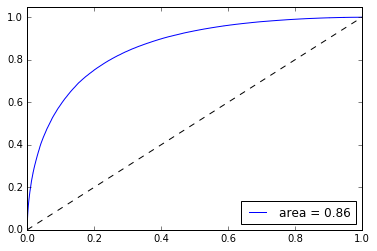

In [26]:
pred_probas = modelNB.predict_proba(X_test)[:,1]
fpr,tpr,roc_thresholds = roc_curve(Y_test, pred_probas)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label='area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')

### Логистическая регрессия (Logistic Regression)

https://basegroup.ru/community/articles/logistic

Создаем объект и обучаем на тренеровочных данных второй алгоритм - Логистическая регрессия (Logistic Regression)

In [27]:
modelLR = LogisticRegression()
modelLR.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Посмотрим как работает обученный алгоритм на тестовых данных

In [28]:
# Predicted outcomes
predicted = modelLR.predict(X_test)

# Actual Expected Outvomes
expected = Y_test

metrics.accuracy_score(expected, predicted)

0.80315499999999995

На тестовых данных получили точность классификации 80,3%. Т.е. этот алгоритм лучше классифицирует твитты, чем Наивный байесовский классификатор

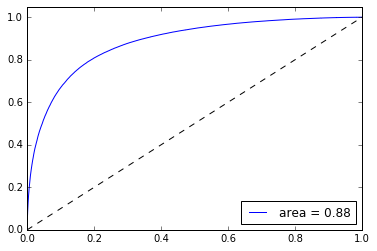

In [29]:
pred_probas = modelLR.predict_proba(X_test)[:,1]
fpr,tpr,roc_thresholds = roc_curve(Y_test, pred_probas)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label='area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')